# 基于MindSpore框架的GAN案例实现

在下面的教程中，我们将通过示例代码说明生成对抗网络GAN如何设置网络、优化器、如何计算损失函数以及如何初始化模型权重。本教程使用的是[MNIST手写数字数据集](http://yann.lecun.com/exdb/mnist/)，共有70000张手写数字图片，包含60000张训练样本和10000张测试样本，图片大小均为28\*28。

# 1 模型讲解

生成式对抗网络（Generative Adversarial Networks，GAN）是一种生成式机器学习模型，是近年来复杂分布上无监督学习最具前景的方法之一。

最初，GAN由Ian J. Goodfellow于2014年发明，并在论文[《Generative Adversarial Nets》](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf)中首次进行了描述，其主要由两个不同的模型共同组成——**生成器**(enerative Model)和**判别器**(Discriminative Model)：

- 生成器的任务是生成看起来像训练图像的“假”图像；
- 判别器需要判断从生成器输出的图像是真实的训练图像还是虚假的图像。

GAN通过设计生成模型和判别模型这两个模块，使其互相博弈学习产生了相当好的输出。



## 1.1 模型简介

GAN模型的核心在于提出了通过对抗过程来估计生成模型这一全新框架。在这个框架中，将会同时训练两个模型——捕捉数据分布的生成模型 $G$ 和估计样本是否来自训练数据的判别模型 $D$ 。

在训练过程中，生成器会不断尝试通过生成更好的假图像来骗过判别器，而判别器在这过程中也会逐步提升判别能力。这种博弈的平衡点是，当生成器生成的假图像和训练数据图像的分布完全一致时，判别器拥有50%的真假判断置信度。

我们首先定义会出现的标记符号：

**判别器的表示**

- $x$：代表图像数据；
- $D(x)$：判别器网络，给出图像判定为真实图像的概率；

在判别过程中，$D(x)$ 需要处理作为二进制文件的大小为 $1\times 28\times 28$ 的图像数据。当 $x$ 来自训练数据时，$D(x)$ 数值应该趋近于 $1$ ；而当 $x$ 来自生成器时，$D(x)$ 数值应该趋近于 $0$ 。因此 $D(x)$ 也可以被认为是传统的二分类器。

**生成器的表示**

- $z$：标准正态分布中提取出的隐码(隐向量)；
- $G(z)$：表示将隐码(隐向量) $z$ 映射到数据空间的生成器函数；

函数 $G(z)$ 的目标是**将服从高斯分布的随机噪声 $z$ 通过生成网络变换为近似于真实分布 $p_{data}(x)$ 的数据分布**，我们希望找到 $θ$ 使得 $p_{G}(x;\theta)$ 和 $p_{data}(x)$ 尽可能的接近，其中 $\theta$ 代表网络参数。

## 1.2 模型结构


$D(G(z))$ 表示生成器 $G$ 生成的假图像被判定为真实图像的概率，如[Goodfellow 的论文](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf)中所述，`D` 和 `G` 在进行一场博弈，`D` 想要最大程度的正确分类真图像与假图像，也就是参数 $\log D(x)$；而 `G` 试图欺骗 `D` 来最小化假图像被识别到的概率，也就是参数 $\log(1−D(G(z)))$。

因此GAN的损失函数为：

$$
\min\limits_{G}\max\limits_{D} V(D,G)=E_{x\sim p_{data}\;\,(x)}[\log D(x)]+E_{z\sim p_{z}\,(z)}[\log (1-D(G(z)))]
$$

从理论上讲，此博弈游戏的平衡点是$p_{G}(x;\theta) = p_{data}(x)$，此时判别器会随机猜测输入是真图像还是假图像。下面我们简要说明生成器和判别器的博弈过程：

![gan](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r1.8/tutorials/application/source_zh_cn/cv/images/gan_image.png)

在上图中，蓝色虚线表示判别器，黑色虚线表示真实数据分布，绿色实线表示生成器生成的虚假数据分布，$z$ 表示隐码，$x$ 表示生成的虚假图像 $G(z)$。

1. 在训练刚开始的时候，生成器和判别器的质量都比较差，生成器会随机生成一个数据分布。
2. 判别器通过求取梯度和损失函数对网络进行优化，将靠近真实数据分布的数据判定为1，将靠近生成器生成出来数据分布的数据判定为0。
3. 生成器通过优化，生成出更加贴近真实数据分布的数据。
4. 生成器所生成的数据和真实数据达到相同的分布，此时判别器的输出为1/2。

根据原论文中的训练方法，是在优化 `D` 的k步和优化 `G` 的1步之间交替进行。这导致 `D` 保持在其最优解附近，只要 `G` 变化得足够慢。过程如下

![method](./step.png)



本案例将使用MNIST手写数字数据集来训练一个生成式对抗网络，接着使用该网络生成动手写数字图片。

此项目文件目录介绍如下：

```text
./mindspore_GAN
├─data_loader.py              # 加载数据集
├─GAN.ipynb                   # 可独立运行总项目的notebook
├─structure.png               # GAN模型结构图
├─test.py                     # 测试模型参数
├─train.py                    # 训练
│      
├─data                        # 数据集
│
├─result
│  ├─gan_mnist.gif           # 保存训练中动图
│  ├─iter.png                # Loss迭代关系图
│  ├─src_data.png            # 抽取显示原始数据集图
│  │
│  ├─images\                 # 生成器生成结果图片
│  │
│  └─checkpoints\      # 模型参数
│
└─src
    ├─configs.py              # 超参数设置
    ├─GAN_model.py            # 模型网络结构
    ├─loss.py                 # 损失函数设置
    ├─TrainOneStep.py         # 训练一步代码
    └─utils.py                # 其他函数代码
```

# 2 案例演示——数据准备

本案例基于MindSpore-GPU版本实现，在GPU上完成模型训练。


## 2.1 数据下载

首先可从[网站](http://yann.lecun.com/exdb/mnist/)将数据集下载到指定目录下并解压（注意本项目将 `t10k-images-idx3-ubyte` 改为 `t10k-images.idx3-ubyte` ）

下载后的数据集目录结构如下：

```text
./data/MNIST_DATA
├── t10k-images.idx3-ubyte
├── t10k-labels.idx1-ubyte
├── train-images.idx3-ubyte
└── train-labels.idx1-ubyte
```

其中训练数据集包含60000张28\*28的手写数字图片的二进制文件，在GAN模型中只需要用到训练数据集。


## 2.2 数据处理

首先为执行过程定义一些输入：

In [2]:
TOTLE_EPOCH = 100         # 训练周期数
latent_size = 100         # 隐码的长度
BATCH_SIZE = 128          # 批量大小
lr = 0.0002               # 学习率
b1 = 0.5                  # Adam优化器的beta1超参数
b2 = 0.999                # Adam优化器的beta2超参数
channels = 1              # 图像通道数
img_size = 28             # 训练图像长宽大小
batch_size_test = 10
batch_size_valid = 1000
gap = 1                   # 判别器等待轮数

定义 `decode_idx3_ubyte` 和 `decode_idx1_ubyte` 函数解析数据

In [2]:
import os
import struct
import random
import numpy as np
from mindspore import dataset

DATA_PATH = 'data/MNIST_DATA'
# train set
train_images_file = os.path.join(DATA_PATH, 'train-images.idx3-ubyte') 
# train labels set
train_labels_file = os.path.join(DATA_PATH, 'train-labels.idx1-ubyte') 
# test set
test_images_file = os.path.join(DATA_PATH, 't10k-images.idx3-ubyte')
# test labels set
test_labels_file = os.path.join(DATA_PATH, 't10k-labels.idx1-ubyte')


"""解析图片数据"""
def decode_idx3_ubyte(idx3_ubyte_file):
    # get the binary date
    bin_data = open(idx3_ubyte_file, 'rb').read()
    offset = 0
    fmt_header = '>iiii'
    magic_number, num_images, num_rows, num_cols = struct.unpack_from(fmt_header, bin_data, offset)
    print('magic numbers :%d, image numbers: %d, image size: %d*%d' % (magic_number, num_images, num_rows, num_cols))
    # parse date set
    image_size = num_rows * num_cols
    offset += struct.calcsize(fmt_header)
    print(offset)
    fmt_image = '>' + str(image_size) + 'B'
    print(fmt_image, offset, struct.calcsize(fmt_image))
    images = np.empty((num_images, num_rows, num_cols))
    for i1 in range(num_images):
        if (i1 + 1) % 10000 == 0:
            print('parsed %d' % (i1 + 1) + 'images')
            print(offset)
        images[i1] = np.array(struct.unpack_from(fmt_image, bin_data, offset)).reshape((num_rows, num_cols))
        offset += struct.calcsize(fmt_image)
    return images

"""解析标签数据"""
def decode_idx1_ubyte(idx1_ubyte_file):
    # get the binary date
    bin_data = open(idx1_ubyte_file, 'rb').read()
    offset = 0
    fmt_header = '>ii'
    magic_number, num_images = struct.unpack_from(fmt_header, bin_data, offset)
    print('magic numbers :%d, image numbers : %d' % (magic_number, num_images))
    # parse date set
    offset += struct.calcsize(fmt_header)
    fmt_image = '>B'
    labels = np.empty(num_images)
    for i2 in range(num_images):
        labels[i2] = struct.unpack_from(fmt_image, bin_data, offset)[0]
        offset += struct.calcsize(fmt_image)
    return labels

class DatasetGenerator:
    def __init__(self):
        self.data = decode_idx3_ubyte(train_images_file).astype("float32")
        self.label = decode_idx1_ubyte(train_labels_file).astype("float32")
    def __getitem__(self, item):
        return self.data[item], self.label[item]
    def __len__(self):
        return len(self.data)

class DatasetGenerator_valid:
    def __init__(self):
        self.data =decode_idx3_ubyte(train_images_file).astype("float32")
        self.label = decode_idx1_ubyte(train_labels_file).astype("float32")
    def __getitem__(self, item):
        return self.data[item], self.label[item]
    def __len__(self):
        return len(self.data)

定义 `create_dataset_train` 函数载入训练数据

In [3]:
# 创建训练数据集,GAN网络只需要训练数据即可
def create_dataset_train(batch_size=64, repeat_size=1, latent_size=100):
    dataset_generator = DatasetGenerator()
    dataset1 = dataset.GeneratorDataset(dataset_generator, ["image", "label"], shuffle=True)
    # 数据映射操作
    mnist_ds = dataset1.map(
        operations=lambda x: (
            x.astype("float32"), # 未归一化
            np.random.normal(size=(latent_size)).astype("float32")
        ),
        output_columns=["image", "latent_code"],
        column_order=["image", "latent_code"]
    )
    # 批量操作
    mnist_ds = mnist_ds.batch(batch_size, True)
    # mnist_ds = mnist_ds.repeat(1)  # 数据加倍
    return mnist_ds

# 获取处理后的数据集
dataset = create_dataset_train(batch_size=BATCH_SIZE, repeat_size=1, latent_size=latent_size)
print(type(dataset))

# 获取数据集大小
iter_size = dataset.get_dataset_size()
print('iter size is %d' % (iter_size))

magic numbers :2051, image numbers: 60000, image size: 28*28
16
>784B 16 784
parsed 10000images
7839232
parsed 20000images
15679232
parsed 30000images
23519232
parsed 40000images
31359232
parsed 50000images
39199232
parsed 60000images
47039232
magic numbers :2049, image numbers : 60000
<class 'mindspore.dataset.engine.datasets.BatchDataset'>
iter size is 468


## 2.3 数据演示

通过 `create_dict_iterator` 函数将数据转换成字典迭代器，然后使用 `matplotlib` 模块可视化部分训练数据。

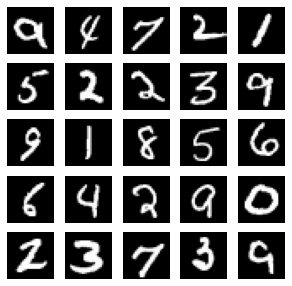

In [4]:
import matplotlib.pyplot as plt
src_data = './result/src_data.png'

# 可视化部分训练数据
def visualize(dataset):
    data_iter = next(dataset.create_dict_iterator(output_numpy=True))

    figure = plt.figure(figsize=(5, 5))
    cols, rows = 5, 5

    for idx in range(1, cols * rows + 1):
        image = data_iter['image'][idx]
        figure.add_subplot(rows, cols, idx)
        plt.axis("off")
        plt.imshow(image.squeeze(), cmap="gray")
    plt.savefig(src_data)
    plt.show()
    
visualize(dataset)

## 2.4 隐码(隐向量)构造

为了跟踪生成器的学习进度，在训练的过程中，我们在每轮epoch结束后，将一组固定的遵循高斯分布的隐码 `test_noise` 输入到生成器中，通过固定隐码所生成的图像来评估生成器的好坏。

In [5]:
from mindspore import Tensor
from mindspore.common import dtype as mstype

# 利用随机种子创建一批隐码
np.random.seed(2323)
test_noise = Tensor(np.random.normal(size=(25, latent_size)), dtype=mstype.float32)
random.shuffle(test_noise)

# 3 案例演示——模型准备

当处理完数据后，就可以来进行网络的搭建了。

本案例实现中所搭建的GAN模型结构与2-14年论文中提出的GAN结构大致相同，但由于所用数据集 MNIST 为单通道小尺寸图片，可识别参数少，便于训练，因此我们只需在判别器和生成器中采用全连接网络架构和Relu激活函数即可达到令人满意的效果。省略了原论文中用于减少参数的 `dropout` 和可学习激活函数 `maxout`。

本案例中采用模型图像如下所示：

![structure](./structure.png)

MindSpore框架构建网络的流程与PyTorch类似，在定义模型类时需要继承Cell类，并重写init和construct方法。

## 3.1 生成器

生成器 `Generator` 的功能是将隐码 `test_noise` 映射到数据空间。由于数据是图像，这一过程也会创建与真实图像大小相同的灰度图像(或RGB彩色图像)。在本案例演示中，该功能通过五层 `Dense` 全连接层来完成的，每层都与 `BatchNorm1d` 批归一化层和 `ReLu` 激活层配对，输出数据会经过 `Tanh` 函数，使其返回 `[-1,1]` 的数据范围内。

此外，我们通过输入部分中设置的 `latent_size`、`img_size` 和 `channels` 来影响代码中的生成器结构:

 - `latent_size` 是隐码 `latent_code` 的长度
 
 - `img_size` 与通过生成器传播的特征图的大小有关
 
 - `channels` 表示生成特征图的通道数

以下是，

 - 生成器的代码实现：

In [1]:
from mindspore import nn
import mindspore.ops.operations as P
import mindspore.ops.functional as F
import mindspore.ops.composite as C

# 重写reshape方法
class Reshape(nn.Cell):
    def __init__(self, shape, auto_prefix=True):
        super().__init__(auto_prefix=auto_prefix)
        self.shape = shape
        self.reshape = P.Reshape()

    def construct(self, x):
        return self.reshape(x, self.shape)

class Generator(nn.Cell):
    def __init__(self, latent_size, auto_prefix=True):
        super(Generator, self).__init__(auto_prefix=auto_prefix)
        self.model = nn.SequentialCell()
        # [N, 100] -> [N, 128]
        self.model.append(nn.Dense(latent_size, 128))  #输入一个100维的0～1之间的高斯分布，然后通过第一层线性变换将其映射到256维
        self.model.append(nn.ReLU())
        # [N, 128] -> [N, 256]
        self.model.append(nn.Dense(128, 256))
        self.model.append(nn.BatchNorm1d(256))
        self.model.append(nn.ReLU())
        # [N, 256] -> [N, 512]
        self.model.append(nn.Dense(256, 512))
        self.model.append(nn.BatchNorm1d(512))
        self.model.append(nn.ReLU())
        # [N, 512] -> [N, 1024]
        self.model.append(nn.Dense(512, 1024))
        self.model.append(nn.BatchNorm1d(1024))
        self.model.append(nn.ReLU())
        # [N, 1024] -> [N, 784]
        self.model.append(nn.Dense(1024, img_size * img_size))  # 经过线性变换将其变成784维
        self.model.append(nn.Tanh())  # 经过Tanh激活函数是希望生成的假的图片数据分布能够在-1～1之间

    def construct(self, x):
        img = self.model(x)
        return Reshape((-1, 1, 28, 28))(img)
    
# 实例化生成器
netGenerator = Generator(latent_size)

NameError: name 'latent_size' is not defined

## 3.2 判别器

如前所述，判别器 `Discriminator` 是一个二分类网络模型，输出判定该图像为真实图的概率。主要通过一系列的 `Dense` 和 `LeakyReLU` 层对其进行处理，最后通过 `Sigmoid` 激活函数，使其返回 `[0, 1]` 的数据范围内，得到最终概率。


 - 判别器的代码实现如下：

In [7]:
class Discriminator(nn.Cell):
    def __init__(self, auto_prefix=True):
        super().__init__(auto_prefix=auto_prefix)
        self.model = nn.SequentialCell()
        # [N, 784] -> [N, 512]
        self.model.append(nn.Dense(img_size * img_size, 512))  #输入特征数为784，输出为512
        self.model.append(nn.LeakyReLU())  #默认斜率为0.2的非线性映射激活函数
        # [N, 512] -> [N, 256]
        self.model.append(nn.Dense(512, 256))  #进行一个线性映射
        self.model.append(nn.LeakyReLU())
        # [N, 256] -> [N, 1]
        self.model.append(nn.Dense(256, 1))
        self.model.append(nn.Sigmoid())  #二分类激活函数，将实数映射到[0,1]
    
    def construct(self, x):
        x_flat = Reshape((-1, img_size * img_size))(x)
        return self.model(x_flat)
    
# 实例化判别器
netDiscriminator = Discriminator()

## 3.3 损失函数

MindSpore将损失函数、优化器等操作都封装到了Cell中，因为GAN结构上的特殊性，其损失是判别器和生成器的多输出形式，这就导致它和一般的分类网络不同。所以我们需要自定义`WithLossCell`类，将网络和Loss连接起来。


当定义了 `Generator` 和 `Discriminator` 后，接下来将使用MindSpore中定义的二进制交叉熵损失函数[BCELoss](https://www.mindspore.cn/docs/zh-CN/r1.8/api_python/nn/mindspore.nn.BCELoss.html)
，为 `Gen` 和 `Dis` 加上损失函数 `GenWithLossCell` 和 `DisWithLossCell`。

- 定义损失函数

In [8]:
from mindspore import nn

# 定义损失函数
adversarial_loss = nn.BCELoss(reduction='mean')

- 连接生成器和损失函数，代码如下：

In [9]:
import mindspore.ops.functional as F

'''连接生成器和损失'''
class GenWithLossCell(nn.Cell):
    def __init__(self, netG, netD, loss_fn, auto_prefix=True):
        super(GenWithLossCell, self).__init__(auto_prefix=auto_prefix)
        self.netG = netG
        self.netD = netD
        self.loss_fn = loss_fn
    '''构建生成器损失计算结构'''
    def construct(self, latent_code2):
        fake_data = self.netG(latent_code2)
        fake_out = self.netD(fake_data)
        loss_G = self.loss_fn(fake_out, F.ones_like(fake_out))
        return loss_G
    
# 实例化WithLossCell
loss_G = GenWithLossCell(netGenerator, netDiscriminator, adversarial_loss)

- 连接判别器和损失函数，代码如下：

In [10]:
'''连接判别器和损失'''
class DisWithLossCell(nn.Cell):
    def __init__(self, netG, netD, loss_fn, auto_prefix=True):
        super(DisWithLossCell, self).__init__(auto_prefix=auto_prefix)
        self.netG = netG
        self.netD = netD
        self.loss_fn = loss_fn
    '''构建判别器损失计算结构'''
    def construct(self, real_data, latent_code1):
        fake_data = self.netG(latent_code1)
        real_out = self.netD(real_data)
        real_loss = self.loss_fn(real_out, F.ones_like(real_out))
        fake_out = self.netD(fake_data)
        fake_loss = self.loss_fn(fake_out, F.zeros_like(fake_out))
        loss_D = real_loss + fake_loss
        return loss_D
    
# 实例化WithLossCell
loss_D = DisWithLossCell(netGenerator, netDiscriminator, adversarial_loss)

## 3.4 优化器

这里设置了两个单独的优化器，`optimizerD` 用于判别器，另一个 `optimizerG` 用于生成器。这两个都是 `lr = 0.0002` 和 `beta1 = 0.5，beta2 = 0.999` 的Adam优化器。

In [11]:
# 为生成器和判别器设置优化器
optimizerD = nn.Adam(netDiscriminator.trainable_params(), learning_rate=lr, beta1=b1, beta2=b2)
optimizerG = nn.Adam(netGenerator.trainable_params(), learning_rate=lr, beta1=b1, beta2=b2)

# 4 案例演示——训练模型

## 4.1 训练准备

训练分为两个主要部分：训练判别器和训练生成器。

- 训练判别器:

   训练判别器的目的是最大程度地提高判别图像真伪的概率。
   
   按照[GAN原论文](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf)的方法，希望通过提高其随机梯度来更新判别器，所以我们要最大化 $log D(x) + log(1 - D(G(z))$ 的值。


- 训练生成器:

   如论文所述，我们希望通过最小化 $log(1 - D(G(z)))$ 来训练生成器，以产生更好的虚假图像。

在这两个部分中，分别获取训练过程中的损失，并在每个周期结束时进行统计，将 `test_noise` 批量推送到生成器中，以直观地跟踪生成器 `Generator` 的训练进度。

下面是，

 - 单次训练过程的函数：

In [12]:
import numpy as np
from mindspore import nn
from mindspore.communication import init

'''TrainOneStepCell'''
class TrainOneStepCell(nn.Cell):
    def __init__(
        self,
        netG: GenWithLossCell,
        netD: DisWithLossCell,
        optimizerG1: nn.Optimizer,
        optimizerD1: nn.Optimizer,
        gap: int,
        sens=1.0,
        auto_prefix=True,
    ):
        super(TrainOneStepCell, self).__init__(auto_prefix=auto_prefix)
        self.netG = netG
        self.netG.set_grad()
        self.netG.add_flags(defer_inline=True)

        self.netD = netD
        self.netD.set_grad()  # 生成需要计算梯度的反向网络
        self.netD.add_flags(defer_inline=True)

        self.weights_G = optimizerG1.parameters
        self.optimizerG1 = optimizerG1
        self.weights_D = optimizerD1.parameters
        self.optimizerD1 = optimizerD1

        self.grad = C.GradOperation(get_by_list=True, sens_param=True) # 灵敏度：返回的梯度乘以灵敏度

        self.sens = sens

        self.reducer_flag = False
        self.grad_reducer_G = F.identity
        self.grad_reducer_D = F.identity

        self.gap = gap

    # train discriminator
    def trainD(self, real_data, latent_code, loss, loss_net, grad, optimizer, weights, grad_reducer):
        sens = P.Fill()(P.DType()(loss), P.Shape()(loss), self.sens)
        grads = grad(loss_net, weights)(real_data, latent_code, sens)
        grads = grad_reducer(grads)
        optimizer(grads)
        return loss

    # train generator
    def trainG(self, latent_code4, loss, loss_net, grad, optimizer, weights, grad_reducer):
        sens = P.Fill()(P.DType()(loss), P.Shape()(loss), self.sens)
        grads = grad(loss_net, weights)(latent_code4, sens) # 先得到gradient function, 再带入参数; sens是grad_wrt_output
        grads = grad_reducer(grads)
        optimizer(grads)
        return loss

    def construct(self, real_data, latent_code5, now_iter):
        d_loss, g_loss = -1, -1
        if now_iter % self.gap == 0:
            loss_D = self.netD(real_data, latent_code5)
            d_loss = self.trainD(real_data, latent_code5, loss_D, self.netD, self.grad, self.optimizerD1, self.weights_D, self.grad_reducer_D)
        
        loss_G = self.netG(latent_code5)
        g_loss = self.trainG(latent_code5, loss_G, self.netG, self.grad, self.optimizerG1, self.weights_G, self.grad_reducer_G)
        return d_loss, g_loss
    
# 实例化TrainOneStepCell
GAN_train = TrainOneStepCell(loss_G, loss_D, optimizerG, optimizerD, gap)

## 4.2 正式训练

在正式进行网络模型训练时，我们设置模型训练的 `epoch` 次数为100轮，并定义训练集 `batch_size` 大小为128。图像尺寸为28\*28，按照高斯分布初始化的25个隐码 `test_noise` 向量长度为100。损失函数使用 `nn.BCELoss`。优化器使用 `nn.Adam`，并设置学习率为0.0002，beta两个超参数分别为0.5和0.999。

一般情况下，由于判别器效果提高较块，为保持两者平衡制约，会使判别器等待生成器，但在本案例中，我们将判别器等待轮数 `gap` 设为1，即指示其无需等待。

每次迭代，均收集当时生成器和判别器的损失，以便于后面绘制训练过程中损失函数的图像(保存至./result/iter.png)。每经过10次迭代，即保存生成器和判别器的网络模型参数(保存至./result/ipynb_checkpoints/)，以便于后面利用参数还原隐码生成的图片。

 - 模型训练部分的代码如下：

[  1/100][  1/468]  Loss_D:1.3861  Loss_G:0.6934
[  1/100][101/468]  Loss_D:1.3901  Loss_G:0.6588
[  1/100][201/468]  Loss_D:1.4021  Loss_G:0.6833
[  1/100][301/468]  Loss_D:1.4741  Loss_G:0.6538
[  1/100][401/468]  Loss_D:1.3508  Loss_G:0.7287
time of epoch 1 is 458.52s
[  2/100][  1/468]  Loss_D:1.3546  Loss_G:0.7360
[  2/100][101/468]  Loss_D:1.3796  Loss_G:0.7203
[  2/100][201/468]  Loss_D:1.3329  Loss_G:0.7703
[  2/100][301/468]  Loss_D:1.3476  Loss_G:0.7055
[  2/100][401/468]  Loss_D:1.4278  Loss_G:0.6801
time of epoch 2 is 4.44s
[  3/100][  1/468]  Loss_D:1.3851  Loss_G:0.6993
[  3/100][101/468]  Loss_D:1.2876  Loss_G:0.9533
[  3/100][201/468]  Loss_D:1.1933  Loss_G:0.8102
[  3/100][301/468]  Loss_D:1.4024  Loss_G:0.7445
[  3/100][401/468]  Loss_D:1.4222  Loss_G:0.7414
time of epoch 3 is 4.33s
[  4/100][  1/468]  Loss_D:1.3120  Loss_G:0.9198
[  4/100][101/468]  Loss_D:1.3007  Loss_G:0.8099
[  4/100][201/468]  Loss_D:1.4068  Loss_G:0.7681
[  4/100][301/468]  Loss_D:1.3251  Loss_G

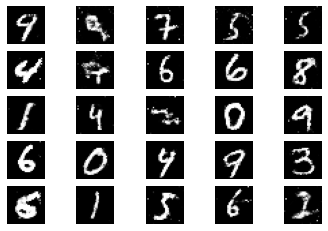

In [13]:
import os
import time
import random
import matplotlib.pyplot as plt
import numpy as np
from mindspore import nn
from mindspore import ops
from mindspore import Tensor, context, save_checkpoint
from mindspore.common import dtype as mstype
from mindspore.common import set_seed
from mindspore.communication import init

# 设置参数保存路径
checkpoints_path = "./result/checkpoints"
os.makedirs(checkpoints_path, exist_ok=True)

# 设置中间过程生成图片保存路径
image_path = "./result/images"
os.makedirs(image_path, exist_ok=True)
def save_imgs(gen_imgs1, idx): # 保存生成的test图像
    for i3 in range(gen_imgs1.shape[0]):
        plt.subplot(5, 5, i3 + 1)
        plt.imshow(gen_imgs1[i3, 0, :, :]/2+0.5, cmap="gray")
        plt.axis("off")
    plt.savefig(image_path+"/{}.png".format(idx))

# 选择执行模式为图模式；指定训练使用的平台为"GPU"，如需使用昇腾硬件可将其替换为"Ascend"
context.set_context(mode=context.GRAPH_MODE, device_target="GPU")
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# set train
netGenerator.set_train()
netDiscriminator.set_train()
# 储存loss和生成图片
G_losses, D_losses = [], []

for epoch in range(TOTLE_EPOCH):
    start = time.time()
    for (iter, data) in enumerate(dataset):
        image, latent_code = data
        image = (image - 127.5) / 127.5 # [0, 255] -> [-1, 1]
        image = ops.Reshape()(image, (image.shape[0], 1, image.shape[1], image.shape[2]))
        d_loss, g_loss = GAN_train(image, latent_code, iter)
        if iter % 100 == 0:
            print('[%3d/%d][%3d/%d]  Loss_D:%6.4f  Loss_G:%6.4f' % (epoch+1, TOTLE_EPOCH, iter+1, iter_size, d_loss.asnumpy(), g_loss.asnumpy()))
    D_losses.append(d_loss.asnumpy())
    G_losses.append(g_loss.asnumpy())
    end = time.time()
    print("time of epoch {} is {:.2f}s".format(epoch+1, end - start))

    # 每个epoch结束后，使用生成器生成一组图片
    netGenerator.set_train(False)
    gen_imgs = netGenerator(test_noise)
    netGenerator.set_train(True)
    save_imgs(gen_imgs.asnumpy(), epoch)

    # 保存网络模型参数为ckpt文件
    if(epoch % 10 == 0):
        save_checkpoint(netGenerator, checkpoints_path+"/Generator%d.ckpt" % (epoch))
        save_checkpoint(netDiscriminator, checkpoints_path+"/Discriminator%d.ckpt" % (epoch))

# 5 案例演示——结果分析

## 5.1 迭代关系图

运行下面代码，描绘 `Dis` 和 `Gen` 损失与训练迭代的关系图：

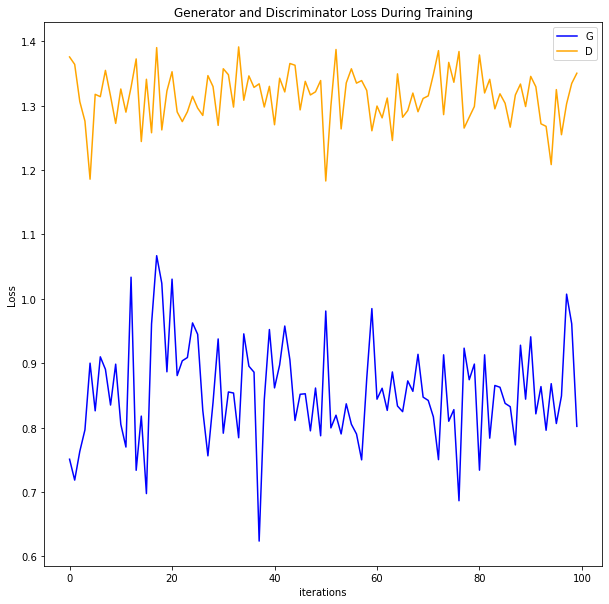

In [14]:
# 设置迭代关系图
iter_path = './result/iter.png'
def paintIters(D_losses, G_losses):
    plt.figure(figsize=(10, 10))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses, label="G", color='blue')
    plt.plot(D_losses, label="D", color='orange')
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(iter_path)
    plt.show()
    
paintIters(D_losses, G_losses)

## 5.2 训练过程动图

为了更加直观的观察多轮训练后生成图像的变化提高，我们通过动图可视化，展现了训练过程中通过隐码 `test_noise` 生成的图像集合。

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cv2
image_list = []
for i in range(100):
    image_list.append(cv2.imread("./result/images/{}.png".format(i), cv2.IMREAD_GRAYSCALE))

gif_path = './result/gan_mnist.gif'
def showGif(image_list):
    show_list = []
    fig = plt.figure(dpi=120)
    for epoch in range(0, len(image_list), 5):
        plt.axis("off")
        show_list.append([plt.imshow(image_list[epoch], cmap='gray')])

    ani = animation.ArtistAnimation(fig, show_list, interval=10, repeat_delay=1000, blit=True)
    ani.save(gif_path, fps=1)

showGif(image_list)

![gan](./result/gan_mnist.gif)

## 5.3 模型检验

从上面的图像可以看出，随着训练次数的增多，图像质量也越来越好。如果增大训练周期数，当 `num_epochs` 达到100以上时，生成的手写数字图片与数据集中的较为相似，下面我们通过加载训练周期为70的生成器网络模型参数文件[Generator.ckpt](./result/checkpoints/Generator70.ckpt)来生成图像，代码如下：

In [4]:
import mindspore
model = Generator(latent_size=100)
param_dict = mindspore.load_checkpoint("./result/checkpoints/Generator70.ckpt")
mindspore.load_param_into_net(model, param_dict)

model.set_train(True)

# 生成图片
test_noise = Tensor(np.random.normal(0, 1, (25, 100)).astype(np.float32))
imgs = model(test_noise).transpose(0, 2, 3, 1).asnumpy()

fig = plt.figure(figsize=(5, 5), dpi=120)
for i in range(25):
    fig.add_subplot(5, 5, i+1)
    plt.axis("off")
    plt.imshow(imgs[i].squeeze(), cmap="gray")
plt.show()

[WARNING] ME(6748:17580,MainProcess):2022-11-06-13:43:52.209.151 [mindspore\train\serialization.py:734] For 'load_param_into_net', remove parameter prefix name: optimizerG1.netG.model., continue to load.
[WARNING] ME(6748:17580,MainProcess):2022-11-06-13:43:52.210.150 [mindspore\train\serialization.py:734] For 'load_param_into_net', remove parameter prefix name: netD.netG.model., continue to load.


NameError: name 'Tensor' is not defined

# 6 总结

本案例基于MindSpore框架针对MNIST数据集，完成了数据读取、数据集构建、GAN模型构建，并根据特定需求自定义了训练轮数和模型框架，进行了模型训练和可视化检验，顺利完成了生成结果的输出。通过此案例进一步加深了对GAN模型结构和特性的理解，并结合MindSpore框架提供的文档和教程，掌握了利用Mindspore框架实现特定案例的流程，以及多种API的使用方法，为以后在实际场景中应用MindSpore框架提供支持。